# Agent Metrics Analysis

This notebook processes and visualizes agent metrics from the monitor.csv file.

In [57]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import numpy as np
import seaborn as sns

In [59]:
from __future__ import annotations

import glob
import os
import time
import csv

import supersuit as ss
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from scipy import stats as sci_stats

import gymnasium as gym 

from pettingzoo.sisl import waterworld_v4, waterworld_model1

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.evaluation import evaluate_policy
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback

import numpy as np 
import pandas as pd

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor


## Set the log directory and process the data

In [56]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
log_dir = "/Users/idil/PettingZoo/SB3-training/logs/no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/"
latest_policy = "/Users/idil/PettingZoo/SB3-training/logs/no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/best_model.zip"

model = RecurrentPPO.load(latest_policy)


In [48]:
obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
num_games = 10 

In [49]:
print(f"Starting eval on {str(env.metadata['name'])}.")
# Initialize data structures to store step-wise information
all_data = []

for game in range(num_games):
    env.reset(seed=game+96)
    print(f"Game {game}")
        
    game_data = {agent: {
            'rewards': [],
            'arousal': [],
            'satiety': [],
            'social-touch': [],
            'social-touch-modulation': [],
            'evader-eaten': [],
            'food_indicator': [],
            'nutrition-per-pursuer': [],
            'poison_indicator': [],
            'step': []
        } for agent in env.possible_agents}
        

    step = 0
    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
            
            
        for a in env.agents:
            game_data[a]['rewards'].append(env.rewards[a])
            game_data[a]['step'].append(step)
                
            for metric in ['arousal', 'satiety', 'social-touch', 'social-touch-modulation', 
                               'evader-eaten', 'food_indicator', 'nutrition-per-pursuer', 'poison_indicator']:
                    if metric in info:
                        parts = info[metric].split('_')
                        agent_name = f"{parts[0]}_{parts[1]}"
                        if parts[2] == "initial":
                            value = 0
                        elif parts[2] == "True":
                            value = 1
                        elif parts[2] == "False":
                            value = 0
                        else:
                            try:
                                value = float(parts[2])
                            except ValueError:
                                print(f"Warning: Unexpected value '{parts[2]}' for {metric}. Setting to None.")
                                value = None
                        game_data[agent_name][metric].append(value)
                    else:
                        game_data[a][metric].append(None)  # or some default value

        if termination or truncation:
            break
        else:
            act = model.predict(obs, deterministic=True)[0]
            
        env.step(act)
        step += 1

    # Convert game data to DataFrame and add to all_data
    for agent, data in game_data.items():
        df = pd.DataFrame(data)
        df['agent'] = agent
        df['game'] = game
        all_data.append(df)

env.close()

# Combine all game data
df = pd.concat(all_data, ignore_index=True)


Starting eval on waterworld_model1.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9


In [ ]:
'''
for agent in env.agent_iter():
    obs, reward, termination, truncation, info = env.last()

    for a in env.agents:
        rewards[a] += env.rewards[a]
        print("reward for agent " + str(a) + " = " + str(rewards[a]))
                # Parse and store metrics
        for metric in ['arousal', 'satiety', 'social_touch']:
            if metric in info:
                value = float(info[metric].split('_')[-1])  # Extract the float value
                episode_metrics[a][metric].append(value)

    if termination or truncation:
        break
    else:
        act, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)

    env.step(act)
'''

In [50]:
# Combine all game data
df = pd.concat(all_data, ignore_index=True)


In [52]:
# Print overall evaluation results
print("\nOverall Evaluation Results:")
for agent in env.possible_agents:
    agent_data = df[df['agent'] == agent]
    print(f"Agent {agent}:")
    print(f" Total Reward: {agent_data['rewards'].sum():.4f}")
    
    # List of all metrics to analyze
    metrics = ['arousal', 'satiety', 'social-touch', 'social-touch-modulation', 'evader-eaten']
    
    for metric in metrics:
        if metric in agent_data.columns:

            # For 'evader-eaten', also show the percentage of True values
            if metric == 'evader-eaten':
                percentage_true = (agent_data[metric] == 1).mean() * 100
                print(f"   Percentage Eating = {percentage_true:.2f}%")
            else: 
                mean_value = agent_data[metric].mean()
                std_value = agent_data[metric].std()
                max_value = agent_data[metric].max()
                min_value = agent_data[metric].min()
                
                print(f" {metric.capitalize()}:")
                print(f"   Mean = {mean_value:.4f}")
                print(f"   Std  = {std_value:.4f}")
                print(f"   Max  = {max_value:.4f}")
                print(f"   Min  = {min_value:.4f}")
    
    print("\n")  # Add a blank line between agents for readability



Overall Evaluation Results:
Agent pursuer_0:
 Total Reward: 18628.0951
 Arousal:
   Mean = 0.5201
   Std  = 0.0811
   Max  = 0.7533
   Min  = 0.3600
 Satiety:
   Mean = 0.9436
   Std  = 0.5468
   Max  = 1.5000
   Min  = 0.0000
 Social-touch:
   Mean = 0.0014
   Std  = 0.0374
   Max  = 1.0000
   Min  = 0.0000
 Social-touch-modulation:
   Mean = 0.0000
   Std  = 0.0023
   Max  = 0.1093
   Min  = -0.0313
   Percentage Eating = 0.00%


Agent pursuer_1:
 Total Reward: 14102.0993
 Arousal:
   Mean = 0.5447
   Std  = 0.0809
   Max  = 0.7527
   Min  = 0.3604
 Satiety:
   Mean = 0.7812
   Std  = 0.5608
   Max  = 1.5000
   Min  = 0.0000
 Social-touch:
   Mean = 0.0000
   Std  = 0.0000
   Max  = 0.0000
   Min  = 0.0000
 Social-touch-modulation:
   Mean = 0.0000
   Std  = 0.0000
   Max  = 0.0000
   Min  = 0.0000
   Percentage Eating = 0.00%




In [34]:
df

,rewards,arousal,satiety,social-touch,social-touch-modulation,evader-eaten,food_indicator,nutrition-per-pursuer,poison_indicator,step,agent,game
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pursuer_0,0
1,-0.056823,0.500333,0.499000,0.0,0.0,0.0,0.0,0.0,0.0,1,pursuer_0,0
2,1.494331,0.500333,0.499000,0.0,0.0,0.0,0.0,0.0,0.0,2,pursuer_0,0
3,-0.056707,0.500667,0.497999,0.0,0.0,0.0,0.0,0.0,0.0,3,pursuer_0,0
4,1.488660,0.500667,0.497999,0.0,0.0,0.0,0.0,0.0,0.0,4,pursuer_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20015,4.300823,0.429612,1.057899,0.0,0.0,0.0,0.0,0.0,0.0,996,pursuer_1,9
20016,-0.000000,0.429573,1.056945,0.0,0.0,0.0,0.0,0.0,0.0,997,pursuer_1,9
20017,4.292862,0.429573,1.056945,0.0,0.0,0.0,0.0,0.0,0.0,998,pursuer_1,9
20018,-0.000000,0.429535,1.055992,0.0,0.0,0.0,0.0,0.0,0.0,999,pursuer_1,9


PLOT RESULTS 

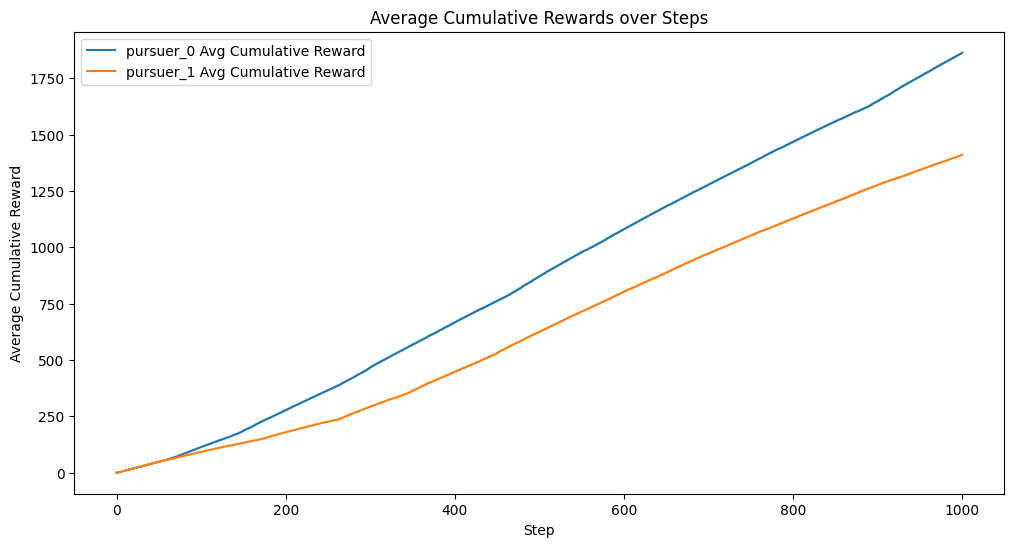

In [53]:
# Create a directory for plots if it doesn't exist
plot_dir = log_dir
# Plot cumulative rewards
plt.figure(figsize=(12, 6))
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]
    cumulative_rewards = agent_data.groupby(['game', 'step'])['rewards'].sum().groupby('step').mean().cumsum()
    plt.plot(cumulative_rewards.index, cumulative_rewards.values, label=f'{agent} Avg Cumulative Reward')
plt.title('Average Cumulative Rewards over Steps')
plt.xlabel('Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
#plt.savefig(f"{plot_dir}/avg_cumulative_rewards.png")

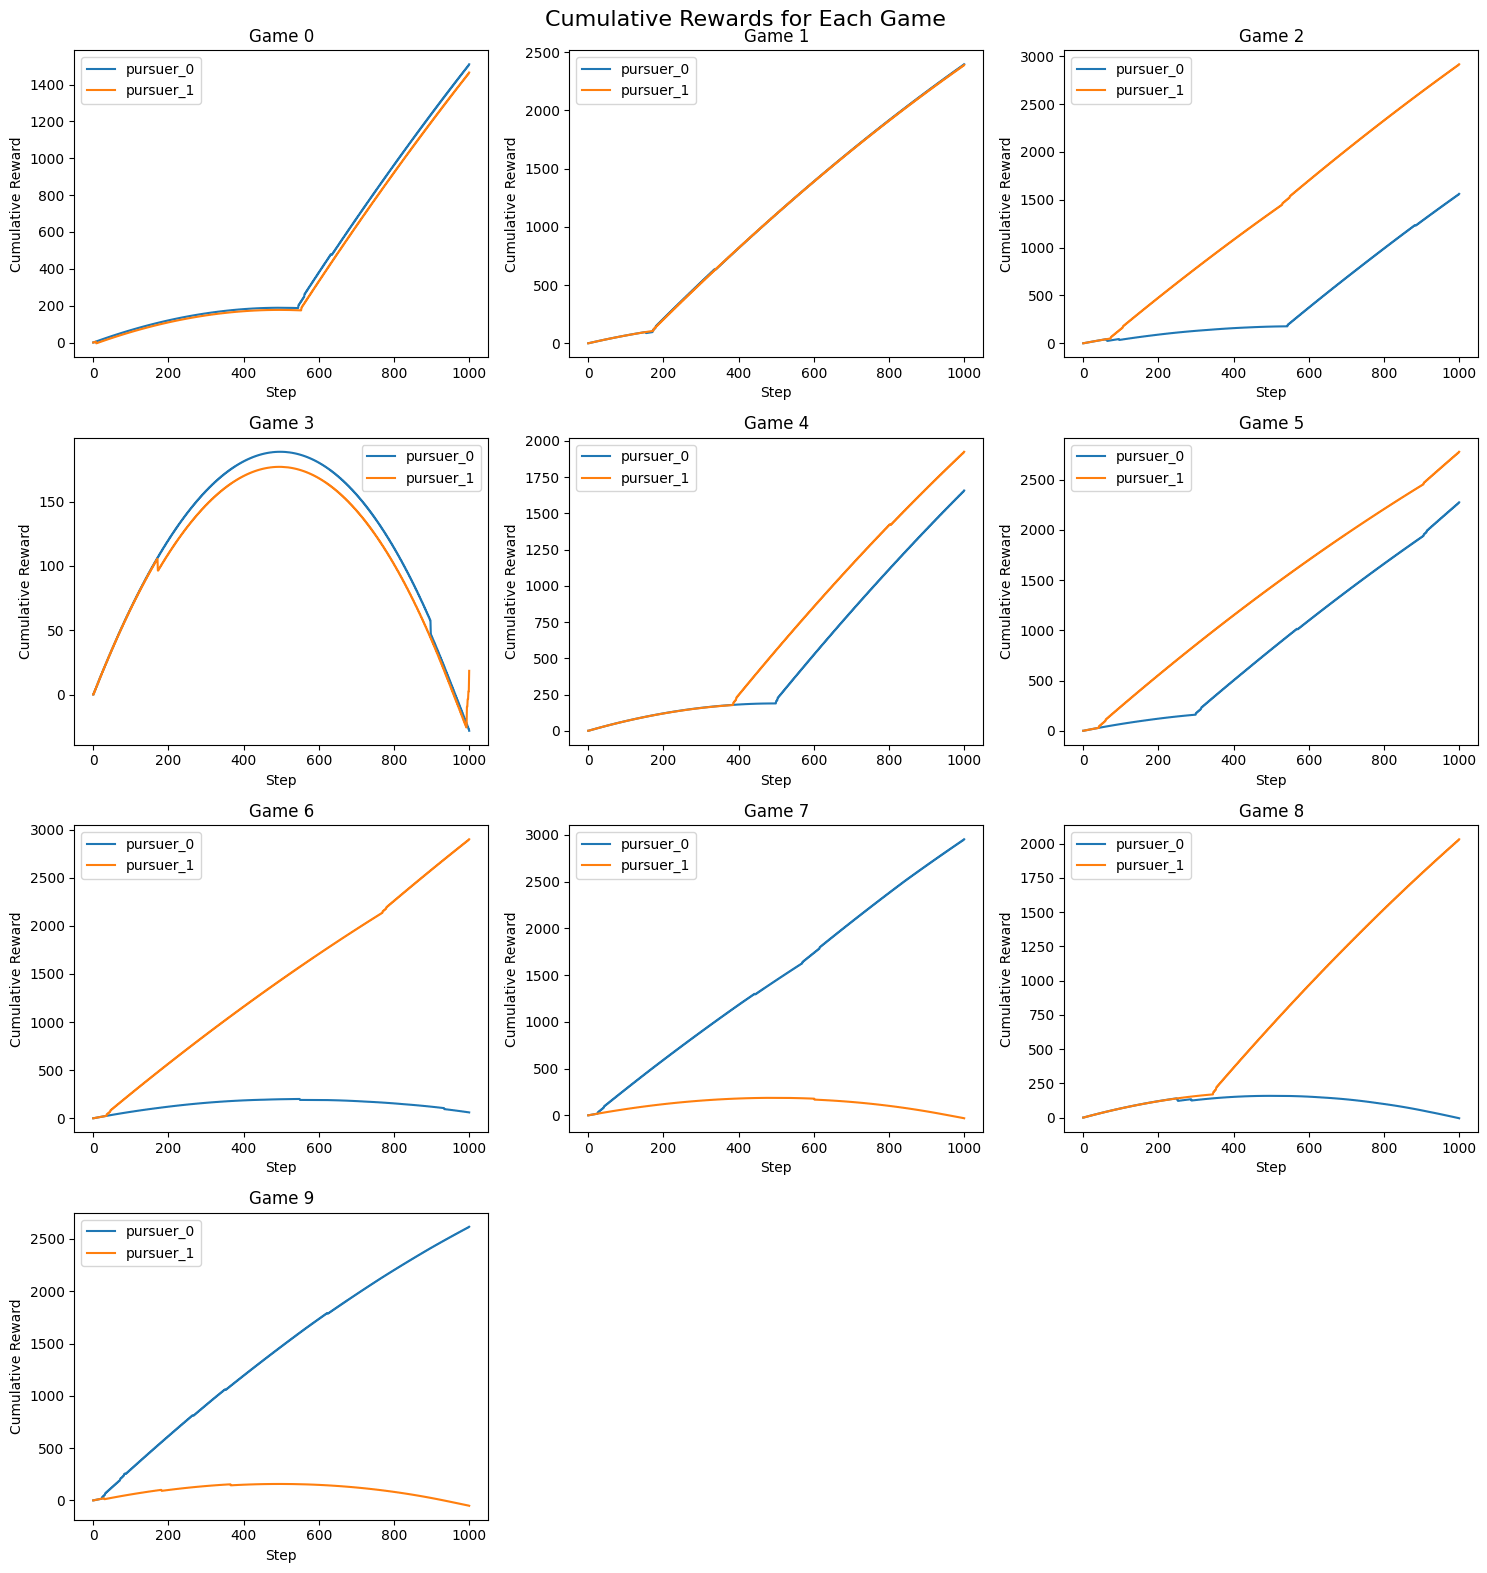

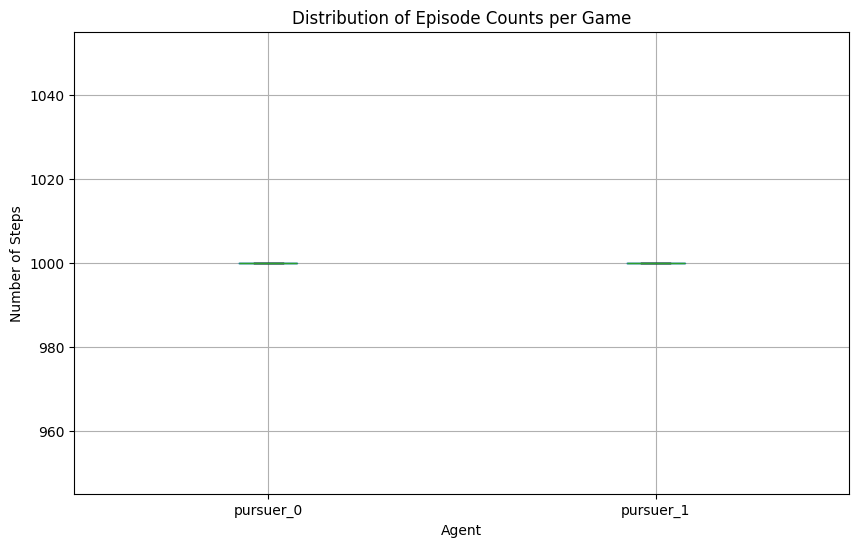

In [26]:
 # Plot cumulative rewards for each game in subplots
num_games = df['game'].nunique()
num_cols = 3  # You can adjust this to change the number of columns in the subplot grid
num_rows = (num_games - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows), squeeze=False)
fig.suptitle('Cumulative Rewards for Each Game', fontsize=16)

for game, ax in zip(df['game'].unique(), axes.flatten()):
    game_data = df[df['game'] == game]
    for agent in game_data['agent'].unique():
        agent_data = game_data[game_data['agent'] == agent]
        cumulative_rewards = agent_data['rewards'].cumsum()
        ax.plot(agent_data['step'], cumulative_rewards, label=agent)
    ax.set_title(f'Game {game}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Cumulative Reward')
    ax.legend()

# Remove any unused subplots
for ax in axes.flatten()[num_games:]:
    ax.remove()

plt.tight_layout()
plt.savefig(f"{plot_dir}/cumulative_rewards_by_game.png")


# Box plot for number of episodes
episode_counts = df.groupby(['game', 'agent'])['step'].max().unstack()
plt.figure(figsize=(10, 6))
episode_counts.boxplot()
plt.title('Distribution of Episode Counts per Game')
plt.xlabel('Agent')
plt.ylabel('Number of Steps')
plt.savefig(f"{plot_dir}/episode_count_boxplot.png")


    

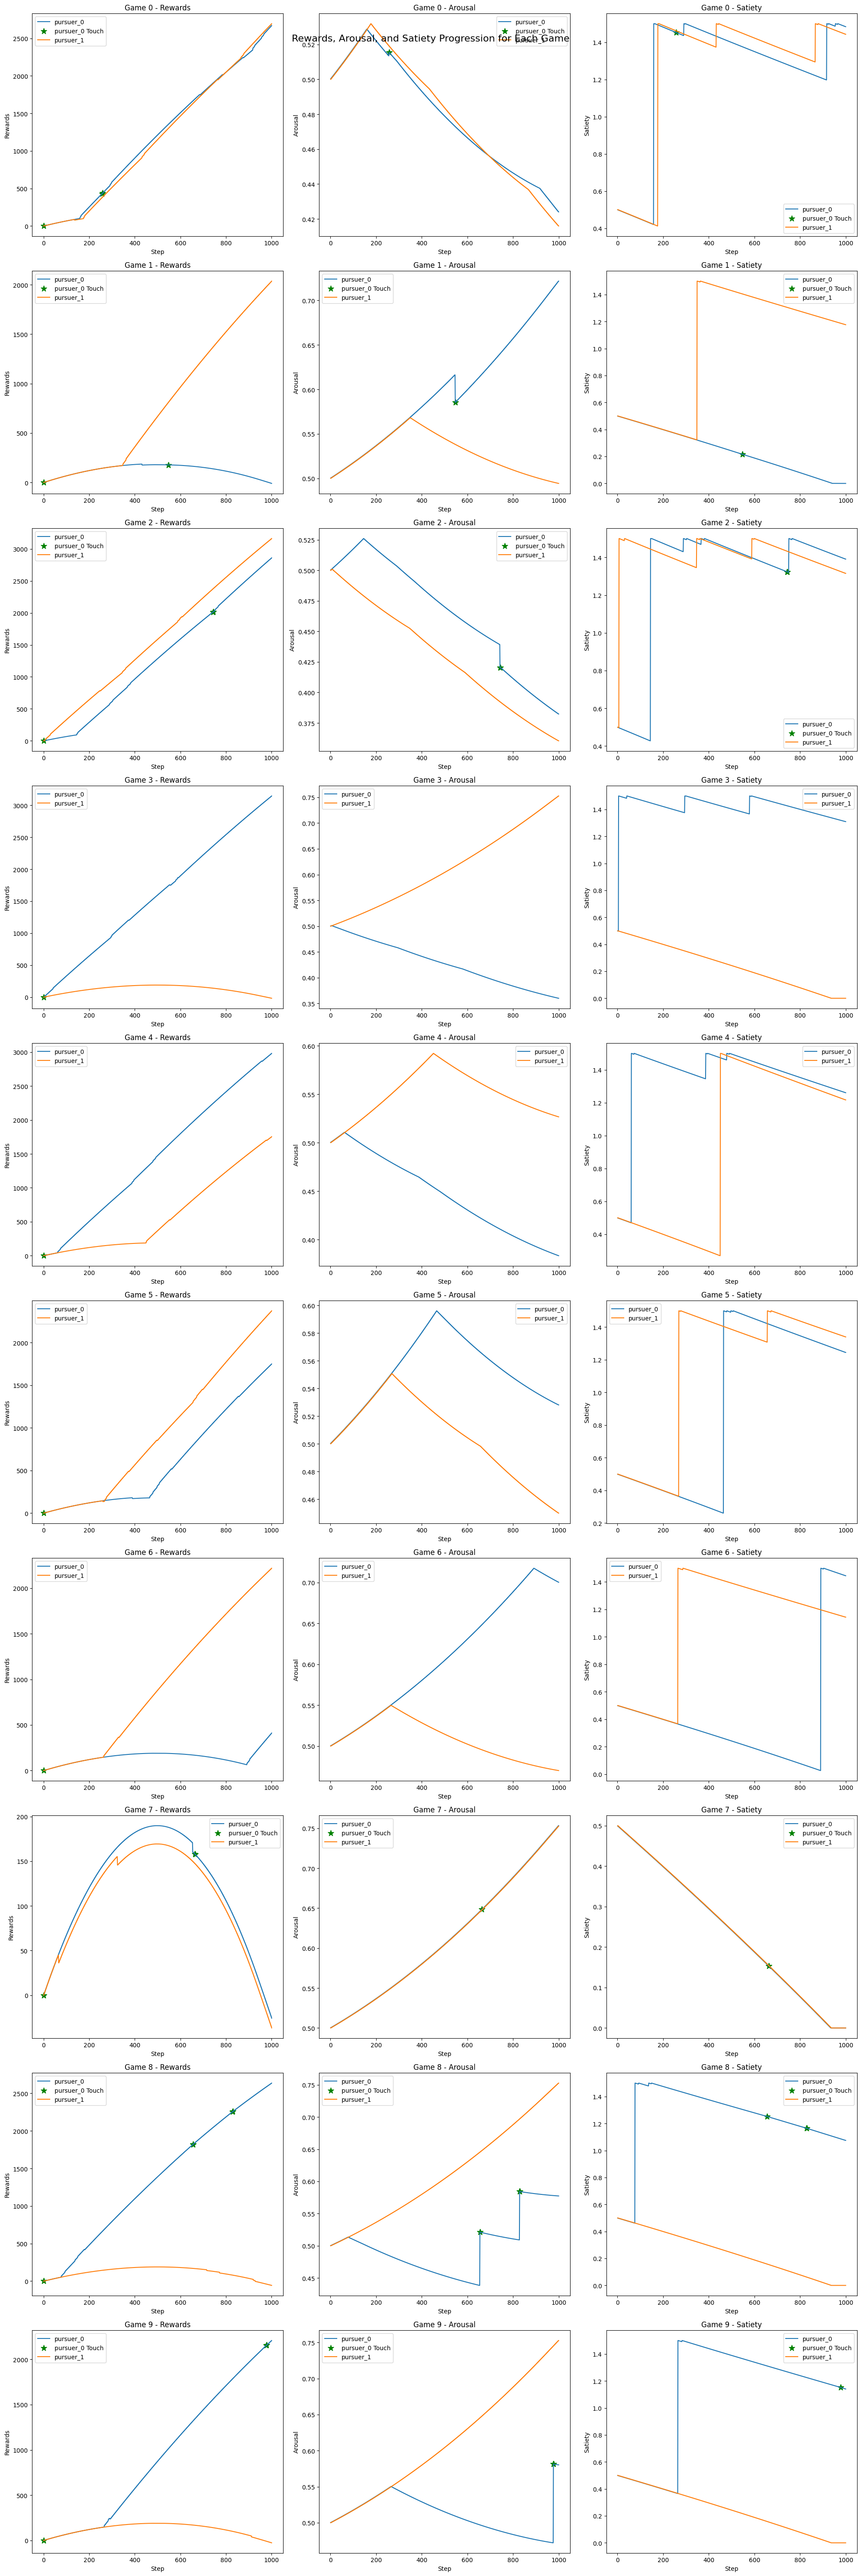

In [54]:
 # Create comprehensive plot for rewards, arousal, and satiety for each game
num_games = df['game'].nunique()
fig, axes = plt.subplots(num_games, 3, figsize=(20, 6*num_games), squeeze=False)
fig.suptitle('Rewards, Arousal, and Satiety Progression for Each Game', fontsize=16)

metrics = ['rewards', 'arousal', 'satiety']
for game, ax_row in zip(sorted(df['game'].unique()), axes):
    game_data = df[df['game'] == game]
    
    for metric, ax in zip(metrics, ax_row):
        for agent in game_data['agent'].unique():
            agent_data = game_data[game_data['agent'] == agent]
            try:
                if metric == 'rewards':
                    values = agent_data[metric].astype(float).cumsum()
                else:
                    values = agent_data[metric].astype(float)
                
                # Plot the metric values
                ax.plot(agent_data['step'], values, label=agent)
                
                # Plot touch events as markers
                touch_events = agent_data[agent_data['social-touch'] != 0]['step']
                ax.scatter(touch_events, values.loc[touch_events.index], 
                            marker='*', s=100, c='green', label=f'{agent} Touch' if touch_events.any() else '')
                
            except (ValueError, TypeError) as e:
                print(f"Warning: Could not plot {metric} for agent {agent} in game {game}. Error: {str(e)}")
                continue
        
        ax.set_title(f'Game {game} - {metric.capitalize()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

plt.tight_layout()
#plt.savefig(f"{plot_dir}/comprehensive_game_metrics_with_touch.png")


In [143]:
from scipy import stats

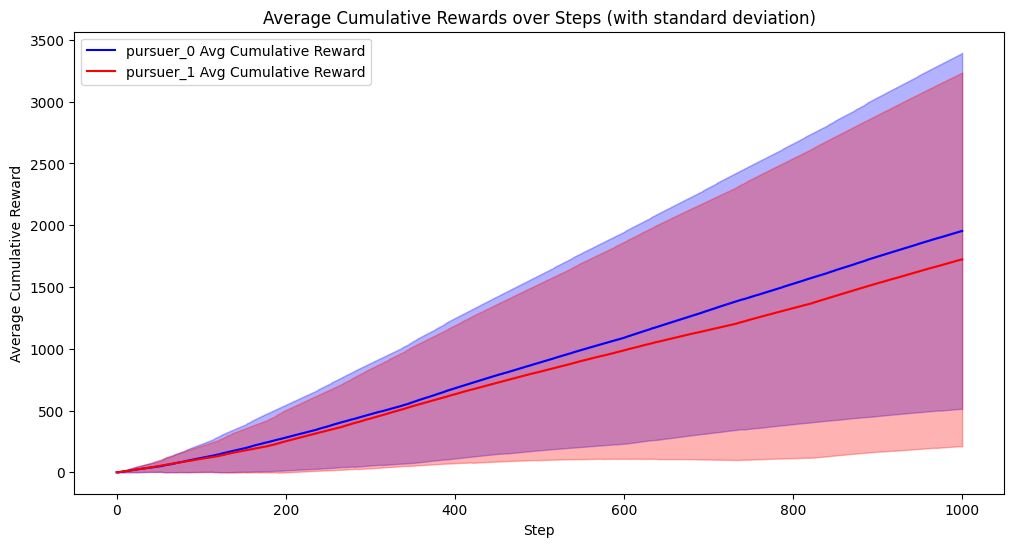

In [18]:
# Plot average cumulative rewards with shaded areas
plt.figure(figsize=(12, 6))
colors = {'pursuer_0': 'blue', 'pursuer_1': 'red'}
for agent in df['agent'].unique():
    try:
        agent_data = df[df['agent'] == agent]
        grouped = agent_data.groupby(['game', 'step'])['rewards'].sum().astype(float).groupby('step')
        cumulative_rewards_mean = grouped.mean().cumsum()
        cumulative_rewards_std = grouped.std().cumsum()
        
        steps = cumulative_rewards_mean.index
        mean_values = cumulative_rewards_mean.values
        std_values = cumulative_rewards_std.values
        
        plt.plot(steps, mean_values, label=f'{agent} Avg Cumulative Reward', color=colors[agent])
        plt.fill_between(steps, 
                         mean_values - std_values, 
                         mean_values + std_values, 
                         alpha=0.3, 
                         color=colors[agent])
    except Exception as e:
        print(f"Warning: Could not plot average cumulative rewards for agent {agent}. Error: {str(e)}")
        continue

plt.title('Average Cumulative Rewards over Steps (with standard deviation)')
plt.xlabel('Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.savefig(f"{plot_dir}/avg_cumulative_rewards_shaded.png")

/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc


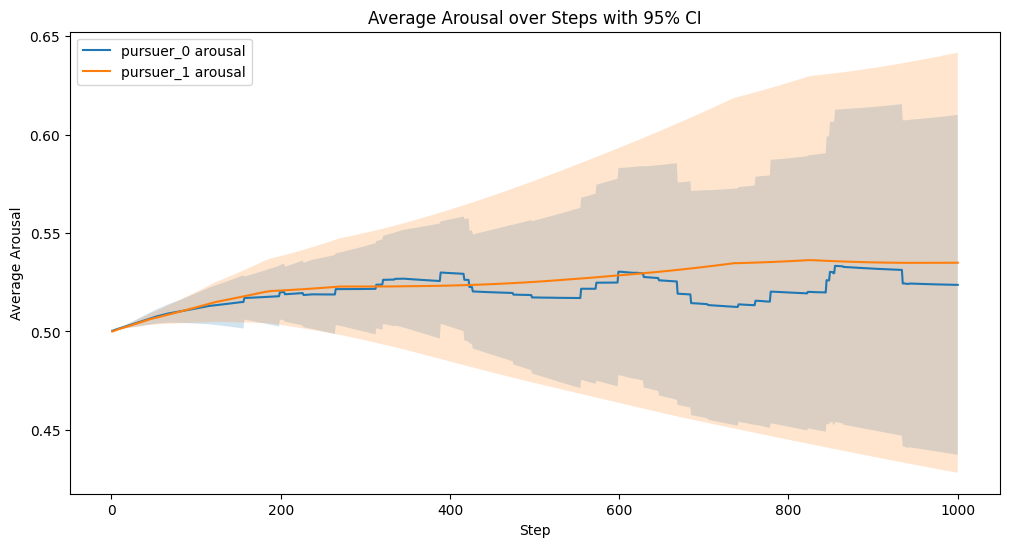

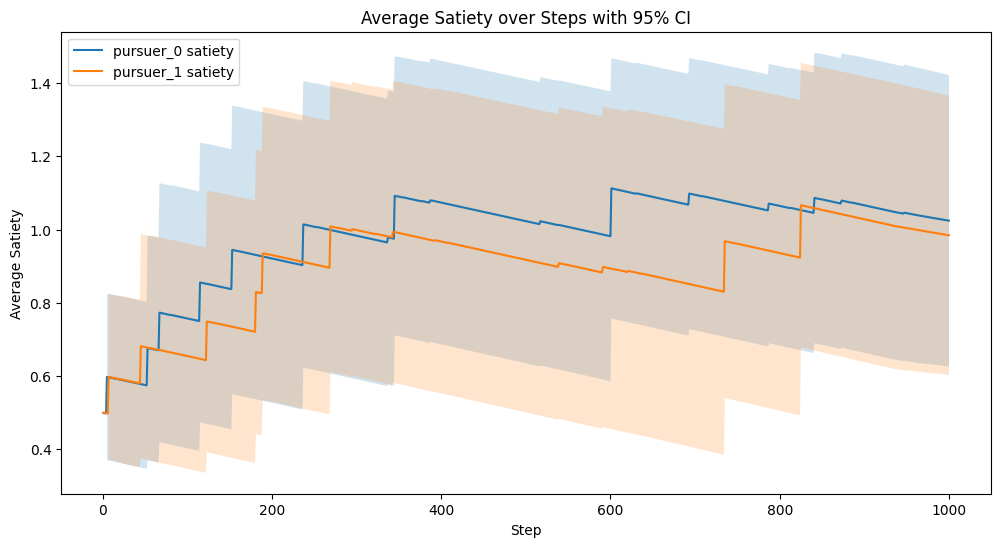

In [19]:
# Plot average metrics with confidence intervals
for metric in metrics[1:]:
    plt.figure(figsize=(12, 6))
    for agent in df['agent'].unique():
        try:
            agent_data = df[df['agent'] == agent]
            numeric_data = agent_data[metric].astype(float)
            means = numeric_data.groupby(agent_data['step']).mean()
            
            def calculate_ci(x):
                try:
                    return stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x))
                except:
                    return (np.nan, np.nan)
            
            ci = numeric_data.groupby(agent_data['step']).agg(calculate_ci)
            ci_lower = [x[0] for x in ci]
            ci_upper = [x[1] for x in ci]
            
            plt.plot(means.index, means.values, label=f'{agent} {metric}')
            plt.fill_between(means.index, ci_lower, ci_upper, alpha=0.2)
        except Exception as e:
            print(f"Warning: Could not plot {metric} for agent {agent}. Error: {str(e)}")
            continue
    
    plt.title(f'Average {metric.capitalize()} over Steps with 95% CI')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.legend()
    plt.savefig(f"{plot_dir}/{metric}_avg_with_ci.png")
    


In [146]:
plt.figure(figsize=(10, 8))
numeric_df = df[metrics].astype(float)
corr_df = numeric_df.groupby(df['agent']).apply(lambda x: x.corr()).reset_index()




<Figure size 1000x800 with 0 Axes>

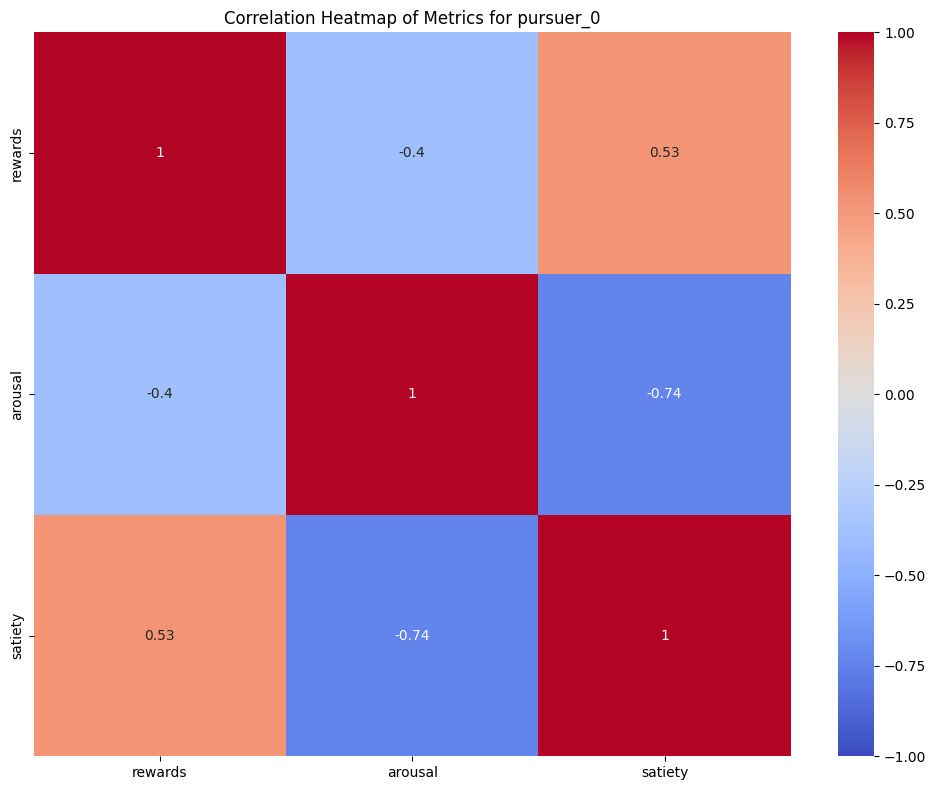

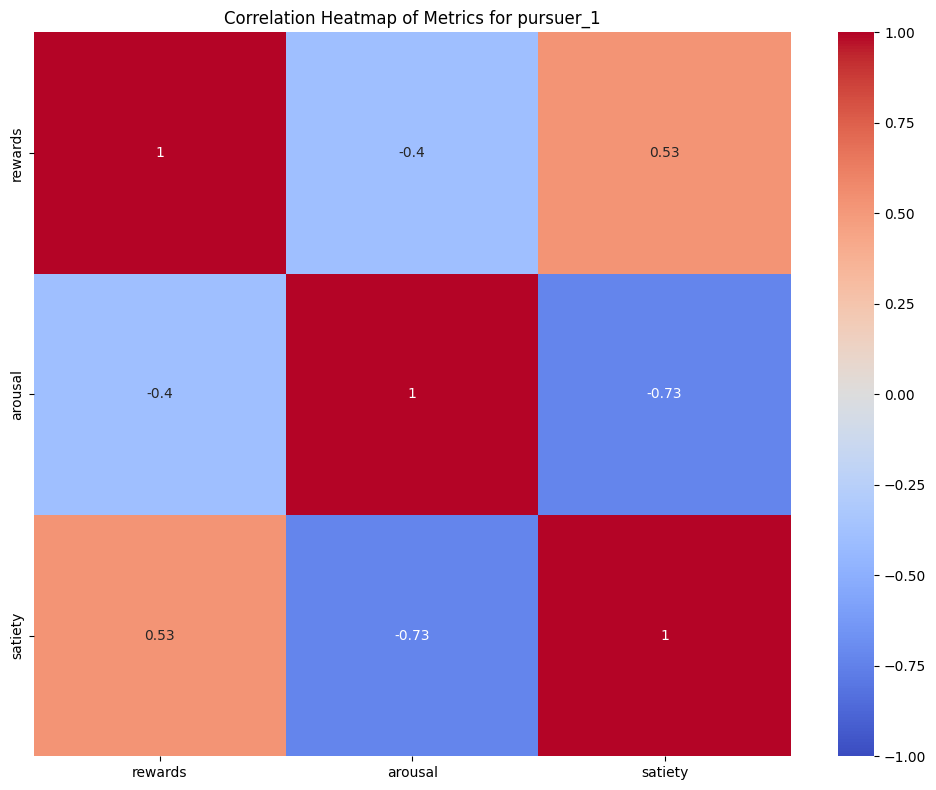

In [147]:
for agent in df['agent'].unique():
    plt.figure(figsize=(10, 8))
    agent_data = df[df['agent'] == agent]
    numeric_data = agent_data[metrics].astype(float)
    corr_matrix = numeric_data.corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Heatmap of Metrics for {agent}')
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/correlation_heatmap_{agent}.png")


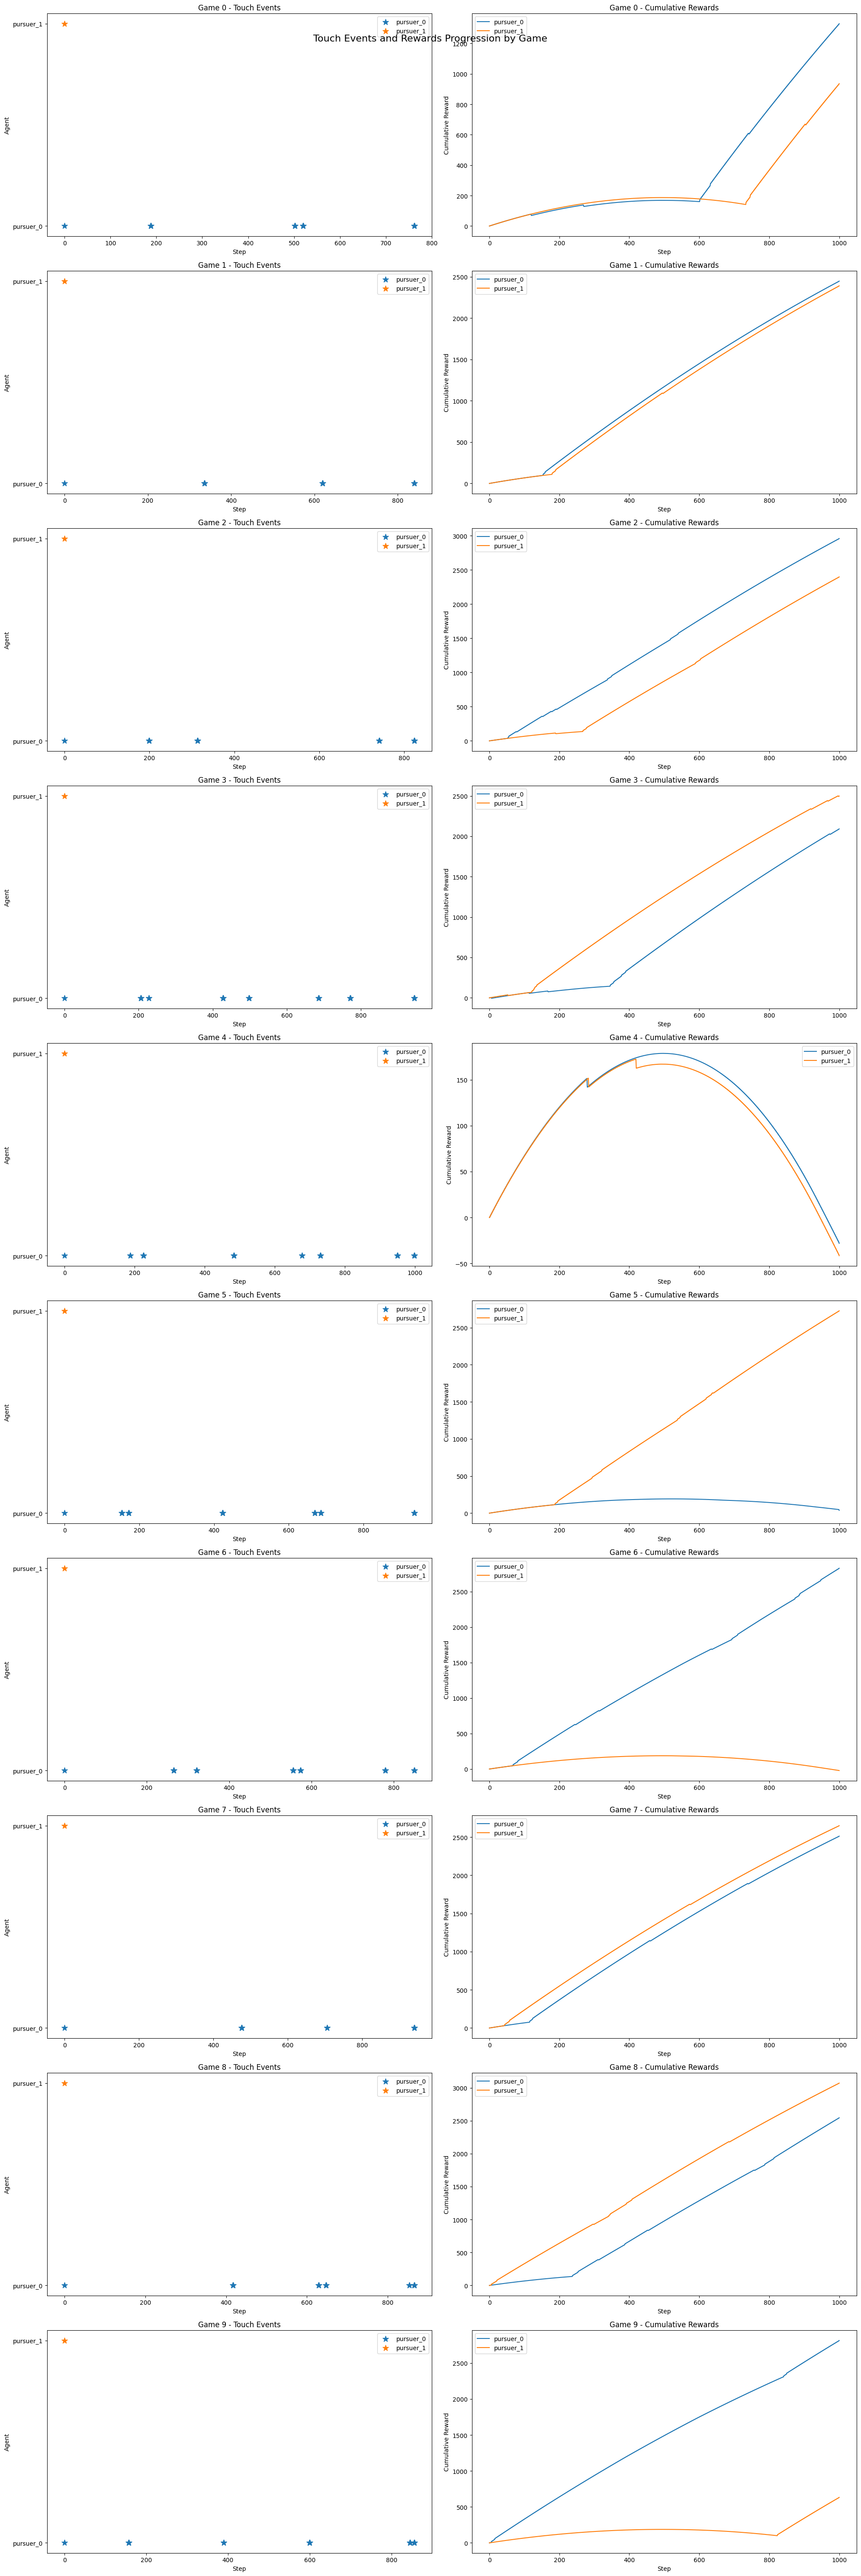

In [20]:
def plot_touch_and_rewards_by_game(df):
        num_games = df['game'].nunique()
        fig, axes = plt.subplots(num_games, 2, figsize=(20, 6*num_games), squeeze=False)
        fig.suptitle('Touch Events and Rewards Progression by Game', fontsize=16)

        for game, ax_row in zip(sorted(df['game'].unique()), axes):
            game_data = df[df['game'] == game]
            
            # Touch events plot
            ax_touch = ax_row[0]
            for agent in game_data['agent'].unique():
                agent_data = game_data[game_data['agent'] == agent]
                touch_events = agent_data[agent_data['social-touch'] != 0]['step']
                ax_touch.scatter(touch_events, [agent]*len(touch_events), 
                                 marker='*', s=100, label=agent)
            
            ax_touch.set_title(f'Game {game} - Touch Events')
            ax_touch.set_xlabel('Step')
            ax_touch.set_ylabel('Agent')
            ax_touch.set_yticks(range(len(game_data['agent'].unique())))
            ax_touch.set_yticklabels(game_data['agent'].unique())
            ax_touch.legend()

            # Rewards progression plot
            ax_rewards = ax_row[1]
            for agent in game_data['agent'].unique():
                agent_data = game_data[game_data['agent'] == agent]
                cumulative_rewards = agent_data['rewards'].astype(float).cumsum()
                ax_rewards.plot(agent_data['step'], cumulative_rewards, label=agent)
            
            ax_rewards.set_title(f'Game {game} - Cumulative Rewards')
            ax_rewards.set_xlabel('Step')
            ax_rewards.set_ylabel('Cumulative Reward')
            ax_rewards.legend()

        plt.tight_layout()
        plt.savefig(f"{plot_dir}/touch_events_and_rewards_by_game.png")
        

# Call the new plotting function
plot_touch_and_rewards_by_game(df)

Comparing two models in no haptic modulation environment and base waterworld environment 

In [73]:

def compare_models(model1, model2, env, num_games=10, seed_start=238):
    def evaluate_model(model):
        obs = env.reset()

            # Cell and hidden state of the LSTM
        lstm_states = None
        num_envs = 1
            # Episode start signals are used to reset the lstm states
        episode_starts = np.ones((num_envs,), dtype=bool)
        num_games = 20

        all_data = []
        for game in range(num_games):
            env.reset(seed=seed_start+game)
            game_data = {agent: {
                'rewards': [], 'arousal': [], 'satiety': [], 
                'social-touch': [], 'evader-eaten': [], 'step': []
            } for agent in env.possible_agents}
            
            step = 0
            for agent in env.agent_iter():
                obs, reward, termination, truncation, info = env.last()
                
                for a in env.agents:
                    game_data[a]['rewards'].append(env.rewards[a])
                    game_data[a]['step'].append(step)
                    
                    for metric in ['arousal', 'satiety', 'social-touch', 'evader-eaten']:
                        if metric in info:
                            parts = info[metric].split('_')
                            agent_name = f"{parts[0]}_{parts[1]}"
                            value = float(parts[2]) if parts[2] not in ['initial', 'True', 'False'] else (0 if parts[2] in ['initial', 'False'] else 1)
                            game_data[agent_name][metric].append(value)
                        else:
                            game_data[a][metric].append(None)
                
                if termination or truncation:
                    break
                else:
                    act = model.predict(obs, deterministic=True)[0]
                env.step(act)
                step += 1
            
            for agent, data in game_data.items():
                df = pd.DataFrame(data)
                df['agent'] = agent
                df['game'] = game
                all_data.append(df)
        
        return pd.concat(all_data, ignore_index=True)

    df1 = evaluate_model(model1)
    df2 = evaluate_model(model2)

    # Determine which metrics to use based on the environment
    if env.metadata['name'] == 'waterworld_v4':
        metrics = ['rewards']
    else:
        metrics = ['rewards', 'arousal', 'satiety', 'social-touch', 'evader-eaten']

    # Convert 'evader-eaten' to 1 (True) and 0 (False) if it exists
    for df in [df1, df2]:
        if 'evader-eaten' in df.columns:
            df['evader-eaten'] = df['evader-eaten'].map({'True': 1, 'False': 0})

    # Plotting
    fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)), sharex=True)
    fig.suptitle('Model Comparison', fontsize=16)

    if len(metrics) == 1:
        axs = [axs]  # Make axs iterable when there's only one subplot

    for i, metric in enumerate(metrics):
        axs[i].set_title(metric.capitalize())
        axs[i].set_ylabel('Value')
        for model_num, df in enumerate([df1, df2], 1):
            mean_values = df.groupby('step')[metric].mean()
            std_error = df.groupby('step')[metric].sem()
            axs[i].plot(mean_values.index, mean_values.values, label=f'Model {model_num}')
            axs[i].fill_between(mean_values.index,
                                mean_values.values - 1.96*std_error.values,
                                mean_values.values + 1.96*std_error.values,
                                alpha=0.2)
        axs[i].legend()

    axs[-1].set_xlabel('Step')
    plt.tight_layout()
    plt.show()

    # Compute and display average and median performance
    print("\nPerformance Comparison:")
    for metric in metrics:
        print(f"\n{metric.capitalize()}:")
        for model_num, df in enumerate([df1, df2], 1):
            avg_performance = df[metric].mean()
            median_performance = df[metric].median()
            print(f"Model {model_num}:")
            print(f"  Average: {avg_performance:.4f}")
            print(f"  Median: {median_performance:.4f}")

    # Calculate and print correlation matrices
    print("\nCorrelation Matrices:")
    for model_num, df in enumerate([df1, df2], 1):
        print(f"\nModel {model_num}:")
        correlation_matrix = df[metrics].corr()
        print(correlation_matrix)
        
        # Visualize the correlation matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f"Correlation Matrix of Metrics - Model {model_num}")
        plt.tight_layout()
        plt.show()

    print("\nStatistical Tests:")
    for metric in metrics:
        print(f"\n{metric.capitalize()}:")
        t_stat, p_value = stats.ttest_ind(df1[metric], df2[metric])
        print(f"Independent t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
        
        u_stat, p_value = stats.mannwhitneyu(df1[metric], df2[metric])
        print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")

        print("\nStatistical Comparison:")
        for metric in metrics:
            _, p_value = sci_stats.ttest_ind(df1[metric], df2[metric])
            print(f"{metric.capitalize()}:")
            print(f"  Model 1 mean: {df1[metric].mean():.4f}")
            print(f"  Model 2 mean: {df2[metric].mean():.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} difference\n")

        social_touch_freq1 = (df1['social-touch'] > 0).mean()
        social_touch_freq2 = (df2['social-touch'] > 0).mean()
        print(f"Social Touch Frequency:")
        print(f"  Model 1: {social_touch_freq1:.4f}")
        print(f"  Model 2: {social_touch_freq2:.4f}")

# Usage:
# compare_models(model1, model2, env)

First: no haptic modulation

In [76]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type": "no_effect"}

# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240824-101114/best_model.zip"
no_haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/best_model.zip"

haptic_model = RecurrentPPO.load(haptic_mod_path)
no_haptic_model = RecurrentPPO.load(no_haptic_mod_path)

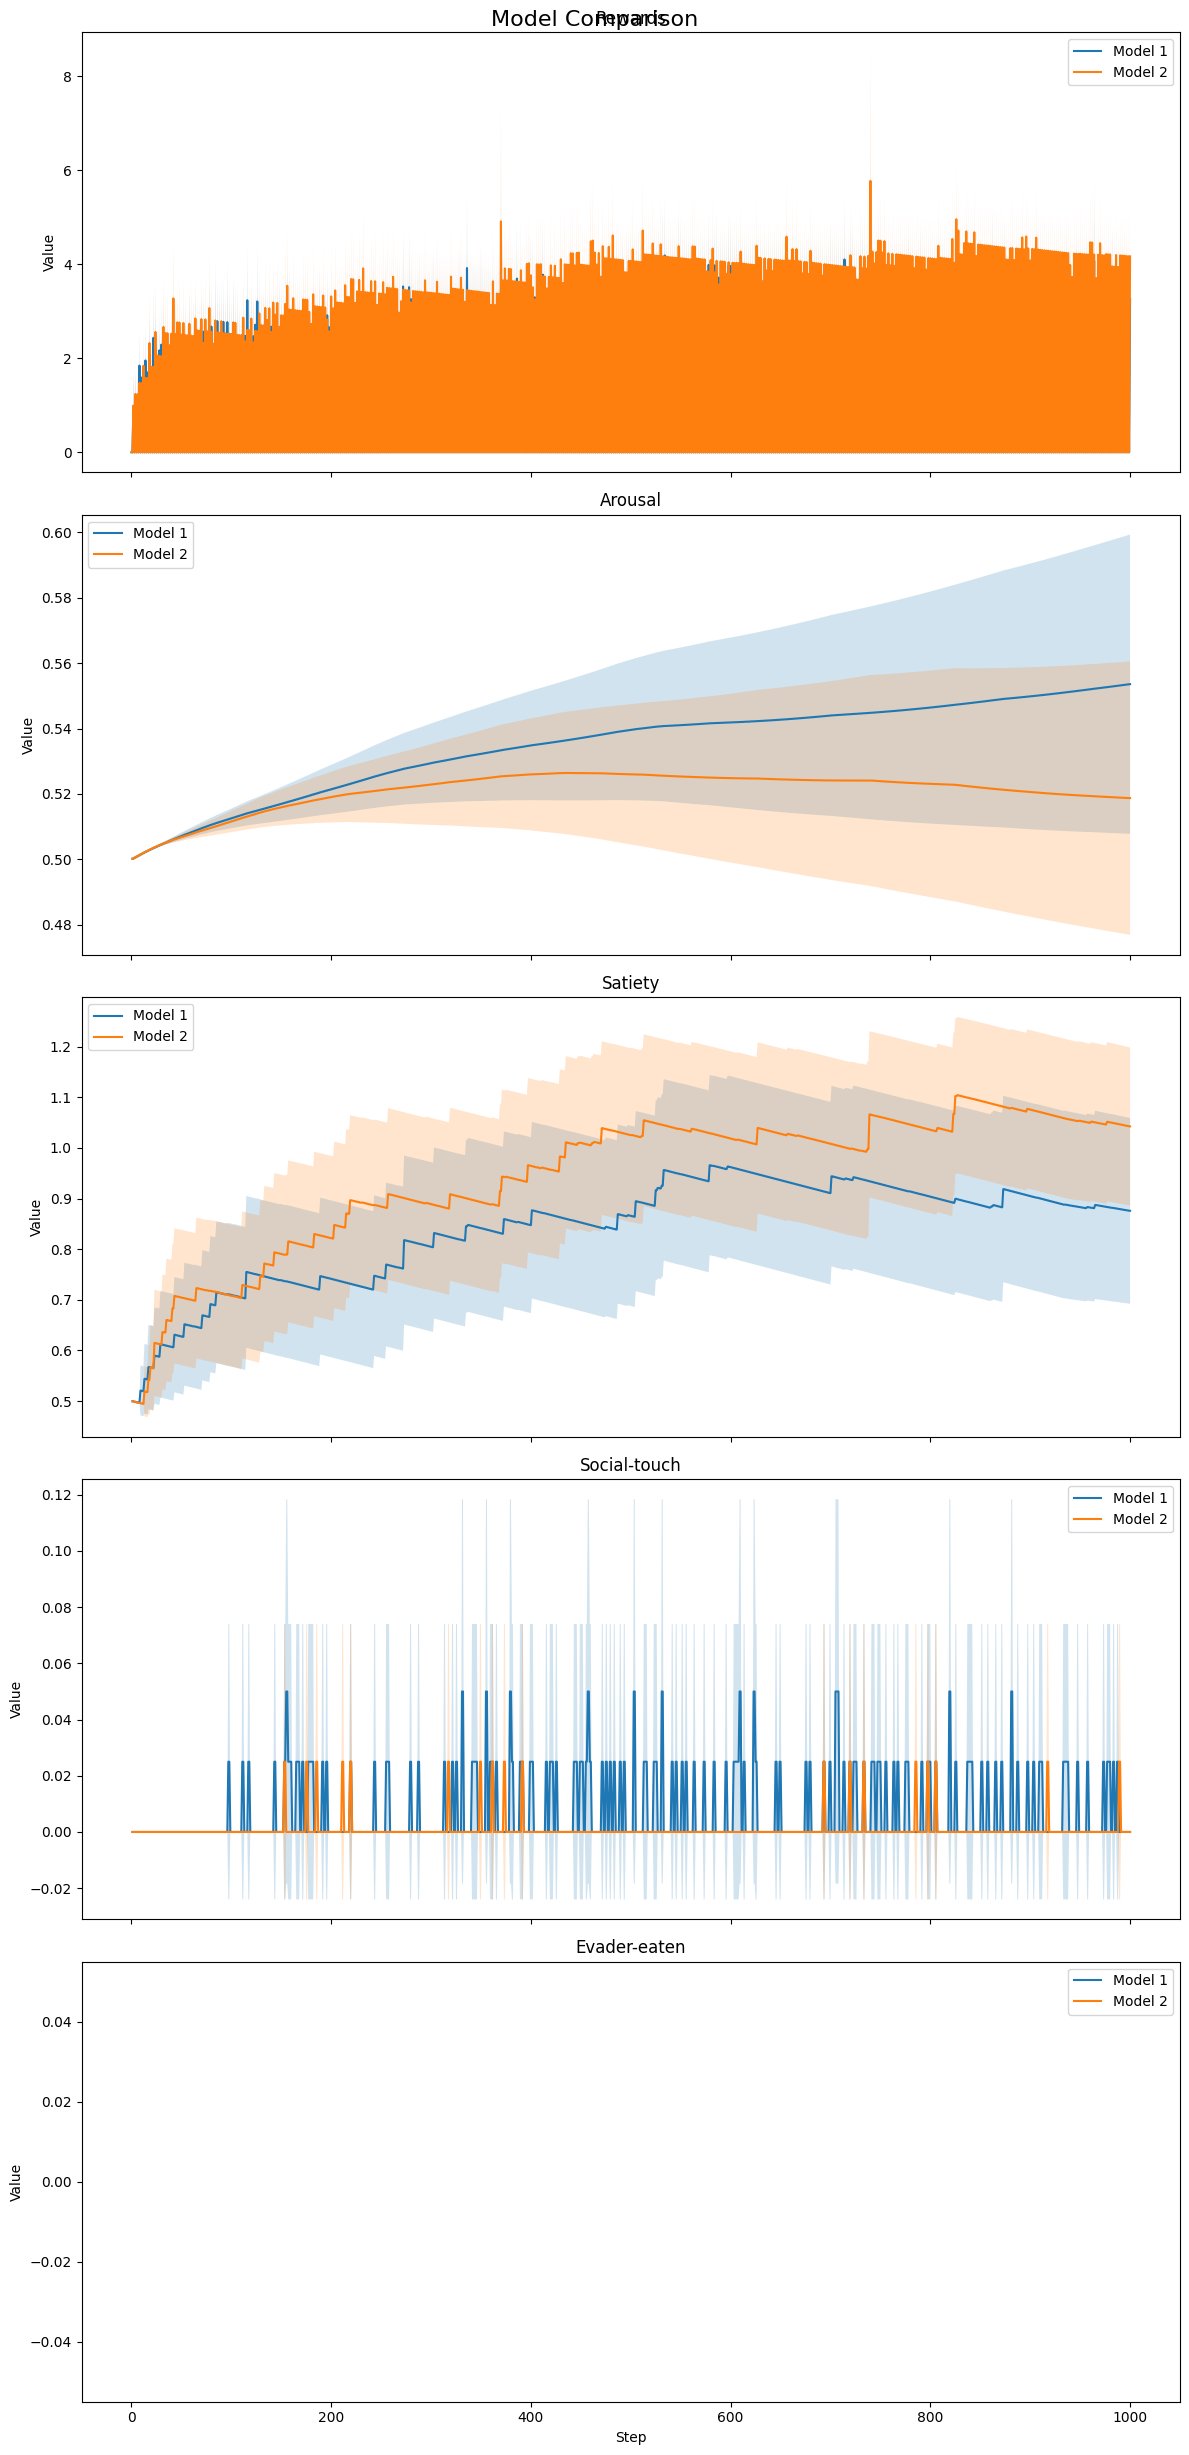


Performance Comparison:

Rewards:
Model 1:
  Average: 1.5714
  Median: 0.0000
Model 2:
  Average: 1.8539
  Median: 0.0000

Arousal:
Model 1:
  Average: 0.5348
  Median: 0.5234
Model 2:
  Average: 0.5209
  Median: 0.5123

Satiety:
Model 1:
  Average: 0.8396
  Median: 1.1149
Model 2:
  Average: 0.9444
  Median: 1.2546

Social-touch:
Model 1:
  Average: 0.0070
  Median: 0.0000
Model 2:
  Average: 0.0009
  Median: 0.0000

Evader-eaten:
Model 1:
  Average: nan
  Median: nan
Model 2:
  Average: nan
  Median: nan

Correlation Matrices:

Model 1:
               rewards   arousal   satiety  social-touch  evader-eaten
rewards       1.000000 -0.378037  0.540834     -0.000271           NaN
arousal      -0.378037  1.000000 -0.679178      0.002529           NaN
satiety       0.540834 -0.679178  1.000000      0.000378           NaN
social-touch -0.000271  0.002529  0.000378      1.000000           NaN
evader-eaten       NaN       NaN       NaN           NaN           NaN


/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


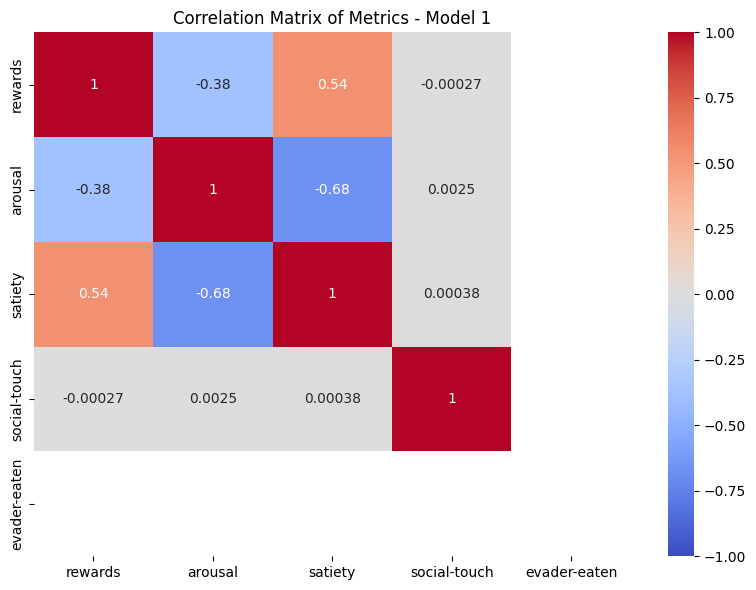


Model 2:
               rewards   arousal   satiety  social-touch  evader-eaten
rewards       1.000000 -0.314461  0.491856     -0.007860           NaN
arousal      -0.314461  1.000000 -0.619591      0.016801           NaN
satiety       0.491856 -0.619591  1.000000     -0.015447           NaN
social-touch -0.007860  0.016801 -0.015447      1.000000           NaN
evader-eaten       NaN       NaN       NaN           NaN           NaN


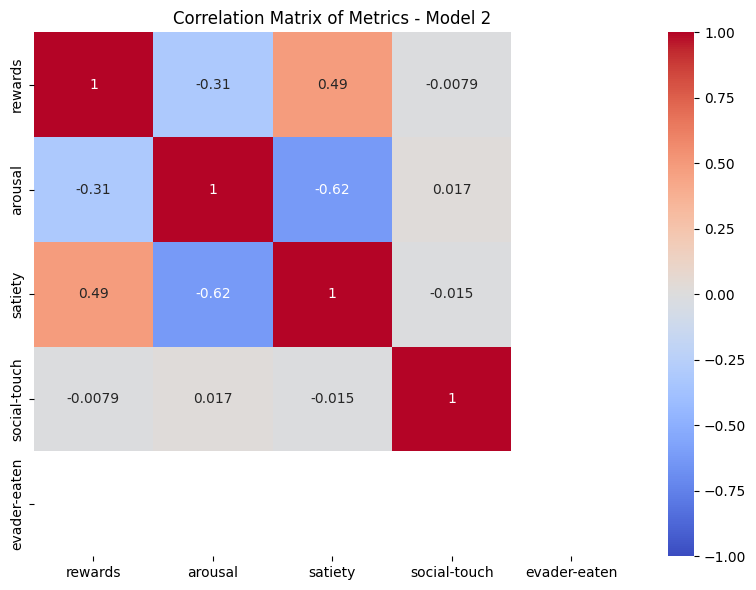


Statistical Tests:

Rewards:
Independent t-test: t-statistic = -14.4617, p-value = 0.0000
Mann-Whitney U test: U-statistic = 707153934.0000, p-value = 0.0000

Statistical Comparison:
Rewards:
  Model 1 mean: 1.5714
  Model 2 mean: 1.8539
  p-value: 0.0000
  Significant difference

Arousal:
  Model 1 mean: 0.5348
  Model 2 mean: 0.5209
  p-value: nan
  Not significant difference

Satiety:
  Model 1 mean: 0.8396
  Model 2 mean: 0.9444
  p-value: nan
  Not significant difference

Social-touch:
  Model 1 mean: 0.0070
  Model 2 mean: 0.0009
  p-value: nan
  Not significant difference

Evader-eaten:
  Model 1 mean: nan
  Model 2 mean: nan
  p-value: nan
  Not significant difference

Social Touch Frequency:
  Model 1: 0.0070
  Model 2: 0.0009

Arousal:
Independent t-test: t-statistic = nan, p-value = nan
Mann-Whitney U test: U-statistic = nan, p-value = nan

Statistical Comparison:
Rewards:
  Model 1 mean: 1.5714
  Model 2 mean: 1.8539
  p-value: 0.0000
  Significant difference

Arousal:
  M

In [77]:
compare_models(haptic_model, no_haptic_model, env)

In [74]:
# Set your log directory here
env_fn = waterworld_v4
env_kwargs = {"n_pursuers" : 2}

# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240824-101114/best_model.zip"
no_haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/best_model.zip"

haptic_model = RecurrentPPO.load(haptic_mod_path)
no_haptic_model = RecurrentPPO.load(no_haptic_mod_path)

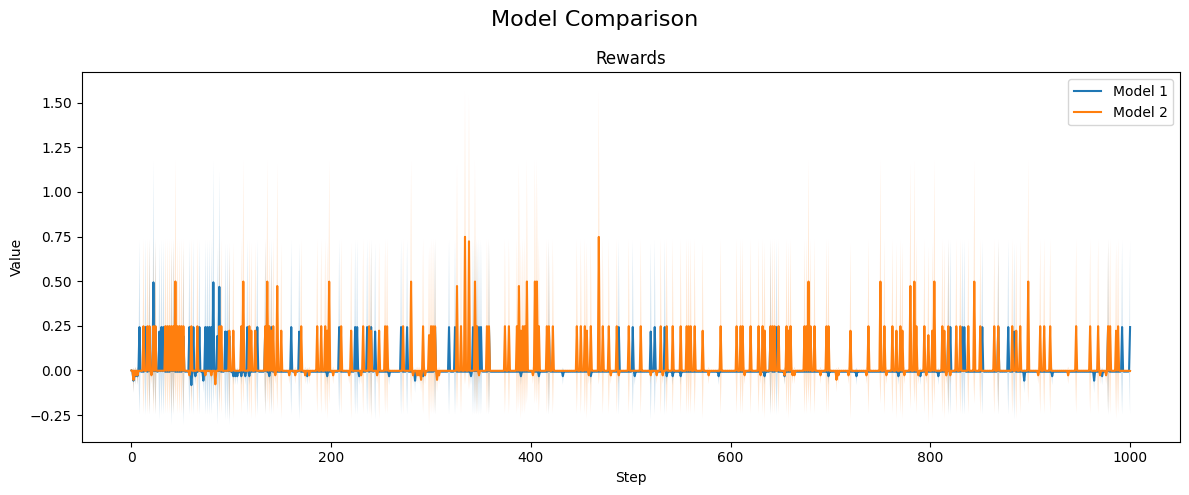


Performance Comparison:

Rewards:
Model 1:
  Average: 0.0104
  Median: 0.0000
Model 2:
  Average: 0.0416
  Median: 0.0000

Correlation Matrices:

Model 1:
         rewards
rewards      1.0


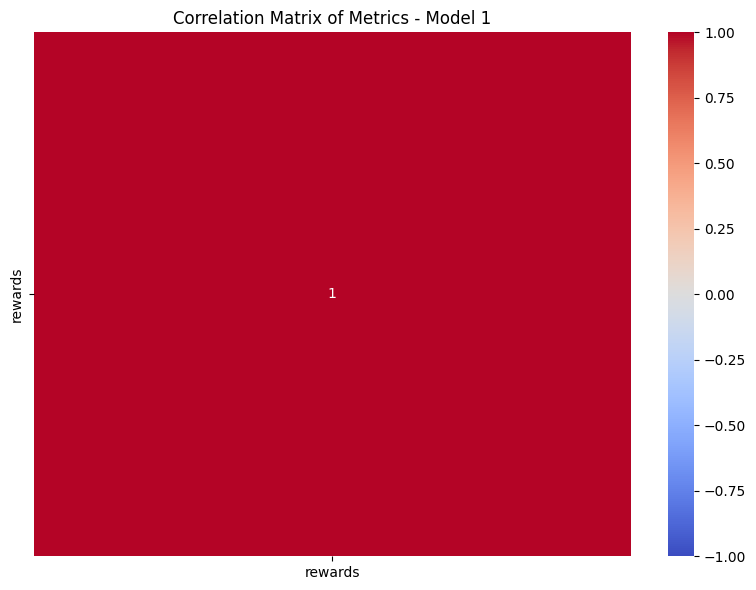


Model 2:
         rewards
rewards      1.0


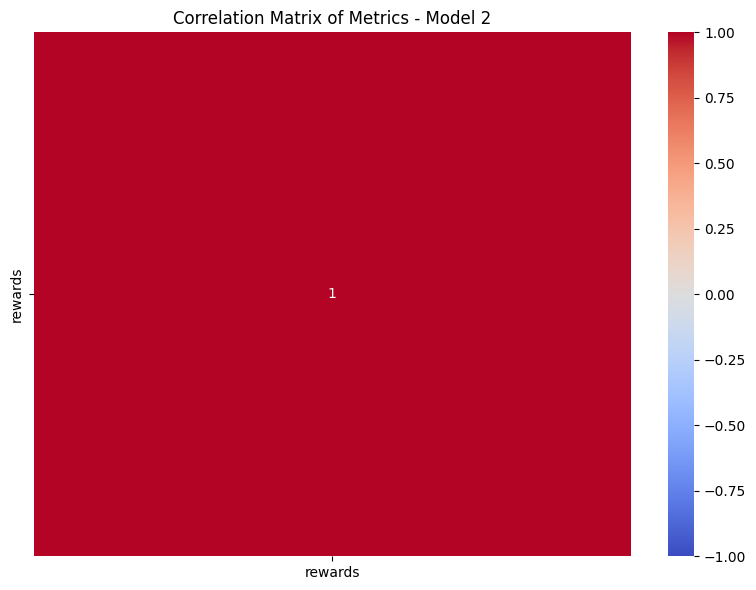


Statistical Tests:

Rewards:
Independent t-test: t-statistic = -7.8760, p-value = 0.0000
Mann-Whitney U test: U-statistic = 595126247.5000, p-value = 0.0000

Statistical Comparison:
Rewards:
  Model 1 mean: 0.0104
  Model 2 mean: 0.0416
  p-value: 0.0000
  Significant difference

Social Touch Frequency:
  Model 1: 0.0000
  Model 2: 0.0000


In [75]:
compare_models(haptic_model, no_haptic_model, env)